In [311]:
import numpy as np
from matplotlib import pyplot as plt 

In [312]:
def load_data(filename):
    mylist = np.genfromtxt(filename, delimiter=',')
    return mylist

In [313]:
data_list = load_data('PCA_MNIST.csv') #this csv file contains the KMNIST data 
# num_classes = 10
# num_features = 10

def train_data(a,b):
    feature_list = []
    labels = []
    for row in data_list[a+1:b+1,1:len(data_list.T)]:
        feature_list.append(row)
    for row in data_list[a+1:b+1,0]:
        y_val = ['1']
        y_val[0] = row
        labels.append(y_val)
    #print (np.array(feature_list[:2]), labels[:10])
    return np.array(feature_list), np.array(labels)

In [314]:
def data_split(m):
    np.random.shuffle(data_list[1:]) # shuffle before splitting into test and training sets

    X_train, Y_train = train_data(0,int(m*60000))
    X_test , Y_test = train_data(int(m*60000),60000)

    X_train = np.array(X_train) 
    X_train = X_train.T/10  # data divided by 10 to reduce the number of thresholds
    X_test = np.array(X_test)
    X_test = X_test.T/10

    m = len(Y_train)
    print (len(X_train[0]))
    return X_train, Y_train, X_test , Y_test

In [315]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        ''' constructor ''' 
        
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        # for leaf node
        self.value = value

In [335]:
class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=2):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, impurity, thresh, curr_depth=0):
        ''' recursive function to build the tree ''' 
        #print(curr_depth)
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            #print("imp1", impurity)
            best_split = self.get_best_split(dataset, num_samples, num_features, impurity, thresh)
            # check if information gain is positive
            if best_split["info_gain"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], impurity, thresh, curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], impurity, thresh, curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features, impurity, thresh='integer'):
        ''' function to find the best split '''
        
        # dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf")
        
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            if thresh == "integer":
                possible_thresholds = np.unique(np.round_(feature_values))
            elif thresh == "2X_thresholds":
                possible_thresholds = np.unique(np.round_(feature_values*2))
            #print(feature_index,"--thresholds--",np.size(possible_thresholds))
            # loop over all the feature values present in the data
            #print("imp2", impurity)
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y, impurity)
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        ''' function to compute information gain '''
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="entropy":
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        elif mode=="entropy_10":
            gain = self.entropy_10(parent) - (weight_l*self.entropy_10(l_child) + weight_r*self.entropy_10(r_child))
        else:
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        return gain
    
    def entropy(self, y):
        ''' function to compute entropy '''
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    def entropy_10(self, y):
        ''' function to compute entropy '''
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log10(p_cls)
        return entropy
    
    def gini_index(self, y):
        ''' function to compute gini index '''
        
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
        
    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''
        
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y, impurity= 'gini', thresh = 'integer'):
        ''' function to train the tree '''
        
        print ("impurity-",impurity,";  Thresholds- ",thresh)
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset, impurity, thresh)
    
    def predict(self, X):
        ''' function to predict new dataset '''
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        ''' function to predict a single data point '''
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

In [327]:
def accuracy_calc(X_test, Y_test):
    Y_pred = classifier.predict(X_test.T) 
    Y_test_= []
    for y in Y_test:
        Y_test_.append(y[0])
    from sklearn.metrics import accuracy_score
    acc = accuracy_score(Y_test_, Y_pred)
    return acc

In [328]:
def plot(A, B, xlabel, ylabel, title):
    plt.plot(A, B)
  
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.title(title)
    plt.show()

In [337]:
X_train, Y_train, X_test , Y_test = data_split(0.5)
classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=5)
classifier.fit(X_train.T,Y_train,'gini')
classifier.print_tree()
acc = accuracy_calc( X_test, Y_test)
print ('Accuracy of the Tree-', acc)

30000
impurity- gini ;  Thresholds-  integer
X_0 <= -23.0 ? 0.07264078774302773
 left:X_4 <= -9.0 ? 0.13737377826388308
  left:X_5 <= 14.0 ? 0.07696768917055974
    left:X_3 <= -21.0 ? 0.058216816409656535
        left:X_4 <= -38.0 ? 0.1559906626415022
                left:X_4 <= -42.0 ? 0.04685472860886858
                                left:6.0
                                right:6.0
                right:X_9 <= 12.0 ? 0.08850038896748297
                                left:7.0
                                right:6.0
        right:X_2 <= -15.0 ? 0.031135075739558538
                left:X_1 <= 0.0 ? 0.26655233816952995
                                left:6.0
                                right:3.0
                right:X_4 <= -35.0 ? 0.019781835305853812
                                left:6.0
                                right:6.0
    right:X_9 <= 25.0 ? 0.10216204642641324
        left:X_0 <= -71.0 ? 0.01855263790977224
                left:X_9 <= 20.0 ? 0.010916482967

In [330]:
classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=5)
classifier.fit(X_train.T,Y_train, 'entropy')
classifier.print_tree()
acc = accuracy_calc( X_test, Y_test)
print ('Accuracy of the Tree-', acc)

impurity- entropy ;  Thresholds-  integer
X_0 <= -18.0 ? 0.5934766711071444
 left:X_2 <= 4.0 ? 0.4400246693089438
  left:X_1 <= -19.0 ? 0.5299504026268917
    left:X_5 <= 22.0 ? 0.3957655664179196
        left:X_4 <= 18.0 ? 0.3379420577790171
                left:X_7 <= -11.0 ? 0.20643676431858693
                                left:7.0
                                right:6.0
                right:X_5 <= 0.0 ? 0.3944487052551777
                                left:3.0
                                right:7.0
        right:X_9 <= 25.0 ? 0.07641417055286126
                left:X_5 <= 30.0 ? 0.04662087777515078
                                left:7.0
                                right:7.0
                right:X_8 <= -5.0 ? 0.3475093997565859
                                left:7.0
                                right:6.0
    right:X_9 <= 9.0 ? 0.2554913769185714
        left:X_0 <= -30.0 ? 0.13995590258795398
                left:X_2 <= -10.0 ? 0.04668672255317735
           

In [331]:
classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=5)
classifier.fit(X_train.T,Y_train, 'entropy_10')
classifier.print_tree()
acc = accuracy_calc( X_test, Y_test)
print ('Accuracy of the Tree-', acc)

impurity- entropy_10 ;  Thresholds-  integer
X_0 <= -18.0 ? 0.17865427973005765
 left:X_2 <= 4.0 ? 0.1324606242941162
  left:X_1 <= -19.0 ? 0.15953096740489825
    left:X_5 <= 22.0 ? 0.11913730674273931
        left:X_4 <= 18.0 ? 0.10173069618789454
                left:X_7 <= -11.0 ? 0.06214365826771062
                                left:7.0
                                right:6.0
                right:X_5 <= 0.0 ? 0.11874089203262905
                                left:3.0
                                right:7.0
        right:X_9 <= 25.0 ? 0.023002957430194593
                left:X_5 <= 30.0 ? 0.014034282634504652
                                left:7.0
                                right:7.0
                right:X_8 <= -5.0 ? 0.10461075310191781
                                left:7.0
                                right:6.0
    right:X_9 <= 9.0 ? 0.07691056808598212
        left:X_0 <= -30.0 ? 0.04213092474920038
                left:X_2 <= -10.0 ? 0.01405410388774845

In [338]:
classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=5)
classifier.fit(X_train.T,Y_train, 'gini', '2X_thresholds')
classifier.print_tree()
acc = accuracy_calc( X_test, Y_test)
print ('Accuracy of the Tree-', acc)

impurity- gini ;  Thresholds-  2X_thresholds
X_0 <= -23.0 ? 0.07264078774302773
 left:X_4 <= -9.0 ? 0.13737377826388308
  left:X_5 <= 14.0 ? 0.07696768917055974
    left:X_3 <= -21.0 ? 0.058216816409656535
        left:X_4 <= -38.0 ? 0.1559906626415022
                left:X_2 <= 63.0 ? 0.030318557273198044
                                left:6.0
                                right:6.0
                right:X_9 <= 12.0 ? 0.08850038896748297
                                left:7.0
                                right:6.0
        right:X_2 <= -15.0 ? 0.031135075739558538
                left:X_1 <= -0.0 ? 0.26655233816952995
                                left:6.0
                                right:3.0
                right:X_4 <= -35.0 ? 0.019781835305853812
                                left:6.0
                                right:6.0
    right:X_9 <= 25.0 ? 0.10216204642641324
        left:X_0 <= -73.0 ? 0.01766447398738344
                left:X_9 <= 21.0 ? 0.01022647713

Train : Test = 1 : 9
6000
impurity- gini ;  Thresholds-  integer
X_0 <= -23.0 ? 0.07433748257143757
 left:X_4 <= -10.0 ? 0.1473014261889387
  left:X_4 <= -28.0 ? 0.07769048416482643
    left:X_3 <= -33.0 ? 0.029287078279563117
        left:7.0
        right:6.0
    right:X_3 <= -17.0 ? 0.0716560984613962
        left:7.0
        right:6.0
  right:X_5 <= 23.0 ? 0.16713971076478096
    left:X_2 <= 2.0 ? 0.1113433597319724
        left:3.0
        right:2.0
    right:X_1 <= -4.0 ? 0.3175908855832452
        left:7.0
        right:2.0
 right:X_3 <= -1.0 ? 0.08165648918902335
  left:X_4 <= -30.0 ? 0.1410113147939821
    left:X_2 <= 18.0 ? 0.033296000554685616
        left:9.0
        right:1.0
    right:X_1 <= 49.0 ? 0.16129756558176855
        left:1.0
        right:2.0
  right:X_2 <= -29.0 ? 0.14933472502184697
    left:X_1 <= -24.0 ? 0.09586833990433397
        left:7.0
        right:4.0
    right:X_1 <= 10.0 ? 0.15948805893348617
        left:8.0
        right:5.0
Accuracy of the Tree- 

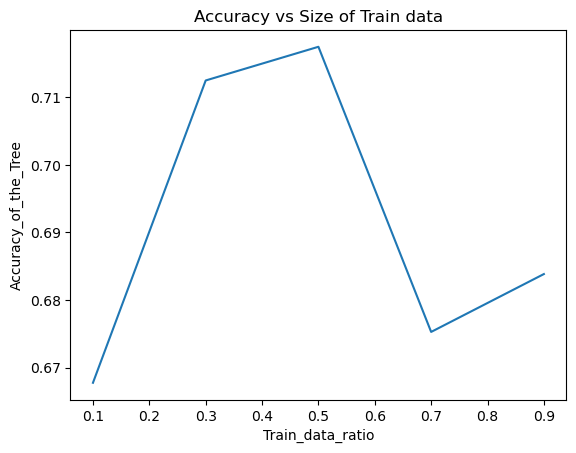

In [332]:
a = 1
split = []
accuracy = []
while a < 10:
    print ('Train : Test =', a,':',10-a )
    X_train, Y_train, X_test , Y_test = data_split(a*0.1)
    classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=3)
    classifier.fit(X_train.T,Y_train)
    classifier.print_tree()
    split.append(a*0.1)
    acc = accuracy_calc( X_test, Y_test)
    accuracy.append(acc)
    print ('Accuracy of the Tree-', acc)
    a = a+2
    
print ('split-', split) 
print ('accuracy-', accuracy) 
plot ( split, accuracy, "Train_data_ratio", "Accuracy_of_the_Tree", "Accuracy vs Size of Train data")

Depth of the Tree = 3
30000
impurity- gini ;  Thresholds-  integer
X_0 <= -23.0 ? 0.07243462975017023
 left:X_4 <= -15.0 ? 0.1387311677006151
  left:X_4 <= -34.0 ? 0.06281745741716
    left:X_3 <= -29.0 ? 0.016609532382067554
        left:6.0
        right:6.0
    right:X_3 <= -17.0 ? 0.07550766532697045
        left:7.0
        right:6.0
  right:X_1 <= -18.0 ? 0.16944603969533656
    left:X_5 <= 23.0 ? 0.14954238087154703
        left:6.0
        right:7.0
    right:X_2 <= 9.0 ? 0.2182550781209036
        left:3.0
        right:2.0
 right:X_3 <= -2.0 ? 0.08243005801551229
  left:X_5 <= 12.0 ? 0.14064112499949366
    left:X_1 <= -33.0 ? 0.16628258909222027
        left:0.0
        right:1.0
    right:X_1 <= 52.0 ? 0.22388523102205632
        left:9.0
        right:2.0
  right:X_2 <= -28.0 ? 0.15189321739557093
    left:X_1 <= -19.0 ? 0.09567969964867917
        left:7.0
        right:4.0
    right:X_1 <= 10.0 ? 0.15663962829569278
        left:8.0
        right:5.0
Accuracy of the Tree

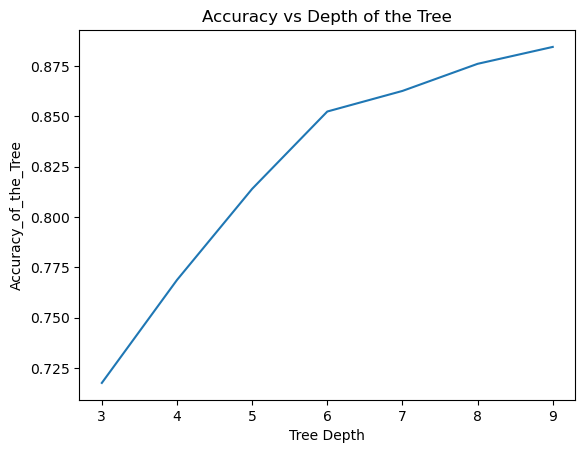

In [333]:
a = 3
spl = []
accuracy = []
while a < 10:
    print ('Depth of the Tree =', a )
    X_train, Y_train, X_test , Y_test = data_split(0.5)
    classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=a)
    classifier.fit(X_train.T,Y_train)
    classifier.print_tree()
    spl.append(a)
    acc = accuracy_calc( X_test, Y_test)
    accuracy.append(acc)
    print ('Accuracy of the Tree-', acc)
    a = a+1
    
print ('Depths-', spl) 
print ('accuracies-', accuracy) 
plot ( spl, accuracy, "Tree Depth", "Accuracy_of_the_Tree", "Accuracy vs Depth of the Tree")

In [334]:
# Y_pred = classifier.predict(X_test.T) 
# print(Y_pred[:10])
# Y_test_= []
# for y in Y_test:
#     Y_test_.append(y[0])
# print(Y_test_[:10])
# from sklearn.metrics import accuracy_score
# accuracy_score(Y_test_, Y_pred)